# **Project Topic: Movie Reviews Using Sentiment Analysis**
## Objective: Understand movie audiences behaviour through their reviews and feedback


## Process:
1.Use a labeled dataset: IMDB movie reviews with positive/negative labels.

2.Preprocess the text data: tokenize, remove stopwords then vectorize.

3.Experiment with different regularization parameters to optimize the model.

4.Train a logistic regression model to classify text as positive or negative.


## **Evaluations:**
1.Do a batch test over random movies to check whether the model is working properly

2.Use metrics like accuracy, precision, recall, and F1 score to evaluate model performance.

3.Analyze feature weights to understand which words have the highest impact on sentiment.

4.Compare the performance of logistic regression with other MLlib classifiers like Naive Bayes or Decision Trees.

## **About dataset**
The dataset having 50K movie reviews from IMDB for natural language processing or Text analytics. It has only 2 columns: reviews & sentiments.



Notes: This project is built based on Scalability and Reproducibility. Any other sentiment datasets (even much larger dataset) from Kaggle will work just fine. The manual download, upload are replaced by automation through coding meaning that this file will be able to work more easily on other computers with Databricks.

In [0]:
# Install necessary packages
!pip install kaggle nltk

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-6c65db7a-5b05-454d-91cb-0d5d60b8e381/bin/python -m pip install --upgrade pip' command.


In [0]:
#Setting up environment to download dataset
!chmod 600 ~/.kaggle/kaggle.json
#Create the .kaggle directory
!mkdir -p ~/.kaggle
#Copy the kaggle.json file to the .kaggle directory
!cp kaggle.json ~/.kaggle/


chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
cp: cannot stat 'kaggle.json': No such file or directory


In [0]:
#Download Dataset directly from Kaggle
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews --force

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 66%|█████████████████████████             | 17.0M/25.7M [00:00<00:00, 24.4MB/s]
100%|██████████████████████████████████████| 25.7M/25.7M [00:00<00:00, 31.5MB/s]


In [0]:
from zipfile import ZipFile
dataset_path = "imdb-dataset-of-50k-movie-reviews.zip"  # Update with the correct path if needed

# Extract files
with ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall("imdb-dataset-of-50k-movie-reviews")
    print("Extraction complete!")

# List extracted files
import os
print(os.listdir("imdb-dataset-of-50k-movie-reviews"))


Extraction complete!
['IMDB Dataset.csv']


In [0]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, udf
from pyspark.sql.types import StringType, ArrayType, IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd
import os
import nltk
from zipfile import ZipFile

In [0]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Sentiment Analysis") \
    .getOrCreate()

In [0]:
#Path to the dataset
import os

extracted_folder = "imdb-dataset-of-50k-movie-reviews"
files = os.listdir(extracted_folder)
print("Files in directory:", files)


Files in directory: ['IMDB Dataset.csv']


In [0]:
csv_file_name = "IMDB Dataset.csv"  # Replace with the actual file name if different
relative_path = os.path.join(extracted_folder, csv_file_name)
print("Relative Path:", relative_path)


Relative Path: imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [0]:
absolute_path = os.path.abspath(relative_path)
print("Absolute Path:", absolute_path)


Absolute Path: /databricks/driver/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [0]:
# Define the absolute path and destination path in DBFS
absolute_path = "/databricks/driver/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv"
dbfs_path = "dbfs:/FileStore/imdb-dataset/IMDB Dataset.csv"

# Copy the file to DBFS
dbutils.fs.cp(f"file://{absolute_path}", dbfs_path)
print(f"File copied to: {dbfs_path}")


File copied to: dbfs:/FileStore/imdb-dataset/IMDB Dataset.csv


In [0]:
# Load data into Spark DataFrame
movies_data = spark.read.csv(
    "dbfs:/FileStore/imdb-dataset/IMDB Dataset.csv",
    header=True,
    inferSchema=True,
    multiLine=True,
    quote='"',
    escape='"'
)
movies_data.show(5)


+--------------------+---------+
|              review|sentiment|
+--------------------+---------+
|One of the other ...| positive|
|A wonderful littl...| positive|
|I thought this wa...| positive|
|Basically there's...| negative|
|Petter Mattei's "...| positive|
+--------------------+---------+
only showing top 5 rows



In [0]:
# Convert Positive to 1 and Negative to 0
movies_data = movies_data.withColumn("sentiment", regexp_replace(col("sentiment"), "positive", "1"))
movies_data = movies_data.withColumn("sentiment", regexp_replace(col("sentiment"), "negative", "0"))
movies_data = movies_data.withColumn("sentiment", col("sentiment").cast("int"))

movies_data.show()



+--------------------+---------+
|              review|sentiment|
+--------------------+---------+
|One of the other ...|        1|
|A wonderful littl...|        1|
|I thought this wa...|        1|
|Basically there's...|        0|
|Petter Mattei's "...|        1|
|Probably my all-t...|        1|
|I sure would like...|        1|
|This show was an ...|        0|
|Encouraged by the...|        0|
|If you like origi...|        1|
|Phil the Alien is...|        0|
|I saw this movie ...|        0|
|So im not a big f...|        0|
|The cast played S...|        0|
|This a fantastic ...|        1|
|Kind of drawn in ...|        0|
|Some films just s...|        1|
|This movie made i...|        0|
|I remember this f...|        1|
|An awful film! It...|        0|
+--------------------+---------+
only showing top 20 rows



### EDA

In [0]:
#1. Data Overview
# Display dataset schema
movies_data.printSchema()

# Check for null values in the 'review' and 'sentiment' columns
movies_data.select(
    (col("review").isNull()).alias("review_null"),
    (col("sentiment").isNull()).alias("sentiment_null")
).groupBy("review_null", "sentiment_null").count().show()

# Show a sample of data
movies_data.show(5, truncate=True)


root
 |-- review: string (nullable = true)
 |-- sentiment: integer (nullable = true)

+--------------------+---------+
|              review|sentiment|
+--------------------+---------+
|One of the other ...|        1|
|A wonderful littl...|        1|
|I thought this wa...|        1|
|Basically there's...|        0|
|Petter Mattei's "...|        1|
+--------------------+---------+
only showing top 5 rows



In [0]:
#2. Dataset Size
# Count total records
total_records = movies_data.count()
print(f"Total records: {total_records}")

# Count records per sentiment
movies_data.groupBy("sentiment").count().show()


Total records: 50000
+---------+-----+
|sentiment|count|
+---------+-----+
|        1|25000|
|        0|25000|
+---------+-----+



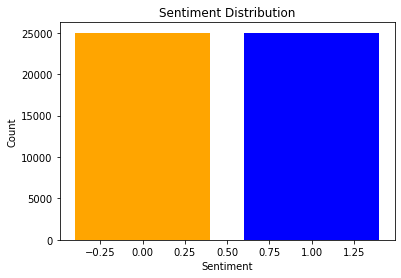

In [0]:
#3. Class Distribution
import matplotlib.pyplot as plt

# Get sentiment counts
sentiment_counts = movies_data.groupBy("sentiment").count().toPandas()

# Plot
plt.figure(figsize=(6, 4))
plt.bar(sentiment_counts['sentiment'], sentiment_counts['count'], color=['blue', 'orange'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()


In [0]:
#4. Word Count Distribution

from pyspark.sql.functions import size, split

# Add a column for word count
movies_data = movies_data.withColumn("word_count", size(split(col("review"), " ")))

# Summary statistics for word count
movies_data.select("word_count").describe().show()


+-------+-----------------+
|summary|       word_count|
+-------+-----------------+
|  count|            50000|
|   mean|        231.14594|
| stddev|171.3264190262364|
|    min|                4|
|    max|             2470|
+-------+-----------------+



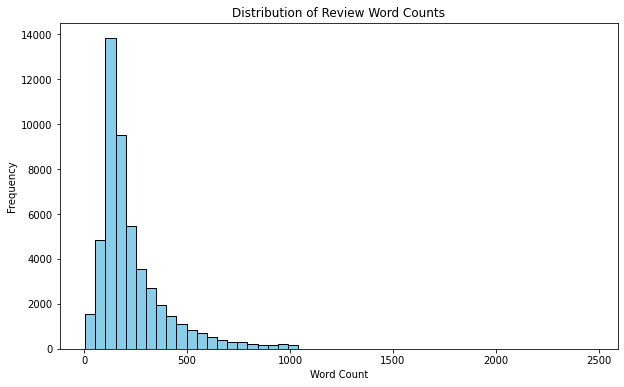

In [0]:
# Convert word count data to Pandas for plotting
word_counts = movies_data.select("word_count").toPandas()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(word_counts["word_count"], bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Review Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


## Preprocess Data

Sample review: "The movie is great! Rated 5/5 by 100+ viewers. #Amazing"

Step 1. Tokenization: Splits text into tokens

SentimentWords: ["The", "movie", "is", "great", "!", "Rated", "5", "5", "by", "100", "+", "viewers", ".", "#Amazing"]

Step 2: Filter Non-Alphabetic Tokens: The filter_alphabetic UDF removes all tokens that are not purely alphabetic

FilteredWords: ["The", "movie", "is", "great", "Rated", "by", "viewers"]

Step 3: Stopword Removal:  Remove common words that do not add significant meaning (e.g., "The", "is", "by").

MeaningfulWords: ["movie", "great", "Rated", "viewers"]

Step 4: Vectorization: Convert the cleaned tokens into a numerical feature vector.

features: (4, [0, 1, 2, 3], [1.0, 1.0, 1.0, 1.0])

where: 

4: Vocabulary size.

Indices [0, 1, 2, 3]: Positions of the words "movie", "great", "Rated", and "viewers" in the vocabulary.

Values [1.0, 1.0, 1.0, 1.0]: Word counts


In [0]:
#Split the dataset into training and testing sets

train, test = movies_data.randomSplit([0.7, 0.3], seed=42)
train_rows=train.count()
test_rows=test.count()

print("Total train :",train_rows)
print("Total test :", test_rows)

Total train : 35036
Total test : 14964


In [0]:
# Step 1: Tokenize the data
tokenizer = Tokenizer(inputCol="review", outputCol="SentimentWords")
tokenized_train = tokenizer.transform(train)
tokenized_test = tokenizer.transform(test)

tokenized_test.show()

+--------------------+---------+--------------------+
|              review|sentiment|      SentimentWords|
+--------------------+---------+--------------------+
|!!!! MILD SPOILER...|        0|[!!!!, mild, spoi...|
|!!!!! POSSIBLE SP...|        0|[!!!!!, possible,...|
|" I have wrestled...|        1|[", i, have, wres...|
|" It had to be Yo...|        0|[", it, had, to, ...|
|"... the beat is ...|        1|["..., the, beat,...|
|"2001: A Space Od...|        1|["2001:, a, space...|
|"200l: A Space Od...|        1|["200l:, a, space...|
|"A Bug's Life" is...|        1|["a, bug's, life"...|
|"A Classic is som...|        1|["a, classic, is,...|
|"A Damsel in Dist...|        0|["a, damsel, in, ...|
|"A Family Affair"...|        1|["a, family, affa...|
|"A Guy Thing" may...|        1|["a, guy, thing",...|
|"A Guy Thing" tri...|        0|["a, guy, thing",...|
|"A Minute to Pray...|        1|["a, minute, to, ...|
|"A Slight Case of...|        1|["a, slight, case...|
|"A Texas communit...|      

In [0]:
# Step 2: Define UDF to filter out non-alphabetic tokens
def filter_alphabetic(tokens):
    return [token for token in tokens if token.isalpha()]

from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, StringType
filter_udf = udf(filter_alphabetic, ArrayType(StringType()))

filtered_train = tokenized_train.withColumn("FilteredWords", filter_udf(col("SentimentWords")))
filtered_test = tokenized_test.withColumn("FilteredWords", filter_udf(col("SentimentWords")))

filtered_test.show()

+--------------------+---------+--------------------+--------------------+
|              review|sentiment|      SentimentWords|       FilteredWords|
+--------------------+---------+--------------------+--------------------+
|!!!! MILD SPOILER...|        0|[!!!!, mild, spoi...|[mild, spoilers, ...|
|!!!!! POSSIBLE SP...|        0|[!!!!!, possible,...|[possible, spoile...|
|" I have wrestled...|        1|[", i, have, wres...|[i, have, wrestle...|
|" It had to be Yo...|        0|[", it, had, to, ...|[it, had, to, be,...|
|"... the beat is ...|        1|["..., the, beat,...|[the, beat, is, t...|
|"2001: A Space Od...|        1|["2001:, a, space...|[a, space, is, se...|
|"200l: A Space Od...|        1|["200l:, a, space...|[a, space, is, a,...|
|"A Bug's Life" is...|        1|["a, bug's, life"...|[is, like, a, fav...|
|"A Classic is som...|        1|["a, classic, is,...|[classic, is, som...|
|"A Damsel in Dist...|        0|["a, damsel, in, ...|[damsel, in, is, ...|
|"A Family Affair"...|   

In [0]:
# Step 3: Remove stopwords

from pyspark.ml.feature import StopWordsRemover

swr = StopWordsRemover(inputCol="FilteredWords", outputCol="MeaningfulWords")
stopwords_removed_train = swr.transform(filtered_train)
stopwords_removed_test = swr.transform(filtered_test)

stopwords_removed_test.show()

+--------------------+---------+--------------------+--------------------+--------------------+
|              review|sentiment|      SentimentWords|       FilteredWords|     MeaningfulWords|
+--------------------+---------+--------------------+--------------------+--------------------+
|!!!! MILD SPOILER...|        0|[!!!!, mild, spoi...|[mild, spoilers, ...|[mild, spoilers, ...|
|!!!!! POSSIBLE SP...|        0|[!!!!!, possible,...|[possible, spoile...|[possible, spoile...|
|" I have wrestled...|        1|[", i, have, wres...|[i, have, wrestle...|[wrestled, unexci...|
|" It had to be Yo...|        0|[", it, had, to, ...|[it, had, to, be,...|[another, sign, h...|
|"... the beat is ...|        1|["..., the, beat,...|[the, beat, is, t...|[beat, strong, de...|
|"2001: A Space Od...|        1|["2001:, a, space...|[a, space, is, se...|[space, set, main...|
|"200l: A Space Od...|        1|["200l:, a, space...|[a, space, is, a,...|[space, supremely...|
|"A Bug's Life" is...|        1|["a, bug

NOTES: Reason to use CountVectorizer instead of HashTF (TF-IDF)

CountVectorizer was chosen for this implementation due to its advantages in interpretability and vocabulary control:

1. **Direct Word Mapping**:
   - CountVectorizer creates a vocabulary where each feature corresponds to an actual word in the dataset, enabling easier analysis of important words.

2. **No Hash Collisions**:
   - HashingTF may map different words to the same feature index, leading to potential information loss. CountVectorizer avoids this by assigning unique indices to words.

4. **Support for Feature Analysis: Identify top Positive, Negative words**:
   - The generated vocabulary can be directly analyzed to understand which words have the most impact on predictions.

These advantages make CountVectorizer particularly useful for tasks where feature interpretability is crucial, such as understanding sentiment drivers in text reviews.

---

In [0]:
from pyspark.ml.feature import CountVectorizer

# Step 4: Vectorize using CountVectorizer
count_vectorizer = CountVectorizer(inputCol="MeaningfulWords", outputCol="features", vocabSize=10000)
count_vectorizer_model = count_vectorizer.fit(stopwords_removed_train)  # Fit on training data

# Transform both training and test datasets
vectorized_train = count_vectorizer_model.transform(stopwords_removed_train)
vectorized_test = count_vectorizer_model.transform(stopwords_removed_test)

# Display results
print("Training Data after Vectorization:")
vectorized_train.select("MeaningfulWords", "features").show(truncate=True, n=5)

print("Testing Data after Vectorization:")
vectorized_test.select("MeaningfulWords", "features").show(truncate=True, n=5)

# Get the vocabulary
vocab = count_vectorizer_model.vocabulary
print("Vocabulary size:", len(vocab))


Training Data after Vectorization:
+--------------------+--------------------+
|     MeaningfulWords|            features|
+--------------------+--------------------+
|[turkish, bath, s...|(10000,[0,1,2,3,5...|
|[spoiler, point, ...|(10000,[1,2,3,4,7...|
|[mild, spoilers, ...|(10000,[0,1,2,3,5...|
|[possible, mild, ...|(10000,[1,3,4,12,...|
|[course, spoilers...|(10000,[1,2,7,9,1...|
+--------------------+--------------------+
only showing top 5 rows

Testing Data after Vectorization:
+--------------------+--------------------+
|     MeaningfulWords|            features|
+--------------------+--------------------+
|[mild, spoilers, ...|(10000,[0,3,5,9,1...|
|[possible, spoile...|(10000,[0,1,3,10,...|
|[wrestled, unexci...|(10000,[1,2,3,9,1...|
|[another, sign, h...|(10000,[0,6,13,17...|
|[beat, strong, de...|(10000,[0,1,2,3,4...|
+--------------------+--------------------+
only showing top 5 rows

Vocabulary size: 10000


**Experiment with different regularization parameters to optimize the model.**

Training Logistic Regression with C=0.01 (regParam=100.0)...
Test Accuracy for C=0.01: 0.7676423416198878
Training Logistic Regression with C=0.1 (regParam=10.0)...
Test Accuracy for C=0.1: 0.8497059609730019
Training Logistic Regression with C=1 (regParam=1.0)...
Test Accuracy for C=1: 0.8712910986367282
Training Logistic Regression with C=10 (regParam=0.1)...
Test Accuracy for C=10: 0.8725608126169473
Training Logistic Regression with C=100 (regParam=0.01)...
Test Accuracy for C=100: 0.8527800053461642

Optimal C: 10.0, Highest Test Accuracy: 0.8725608126169473


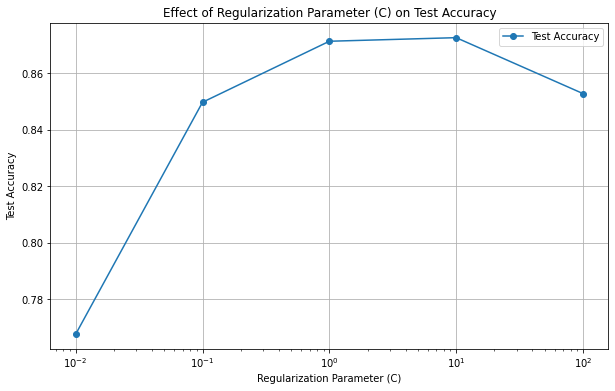

In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt

# Define the range of C values (inverse of regParam)
C_values = [0.01, 0.1, 1, 10, 100]

# Initialize evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment", 
    predictionCol="prediction", 
    metricName="accuracy"
)

# Store results for each C value
results = []

# Ensure the 'sentiment' column is of integer type in vectorized data
vectorized_test = vectorized_test.withColumn("sentiment", col("sentiment").cast("int"))

# Loop through C values
for C in C_values:
    print(f"Training Logistic Regression with C={C} (regParam={1/C})...")
    
    # Initialize Logistic Regression model with the given C value
    lr = LogisticRegression(maxIter=1000, regParam=1/C, elasticNetParam=0, labelCol="sentiment")
    
    # Train the model
    lr_model = lr.fit(vectorized_train)
    
    # Make predictions on the test set
    predictions = lr_model.transform(vectorized_test)
    
    # Evaluate accuracy
    accuracy = evaluator.evaluate(predictions)
    
    # Append results
    results.append({"C": C, "Test Accuracy": accuracy})
    print(f"Test Accuracy for C={C}: {accuracy}")

# Convert results to Pandas DataFrame
results_df = pd.DataFrame(results)

# Find the optimal C value
optimal_row = results_df.loc[results_df['Test Accuracy'].idxmax()]
optimal_C = optimal_row['C']
highest_accuracy = optimal_row['Test Accuracy']

print(f"\nOptimal C: {optimal_C}, Highest Test Accuracy: {highest_accuracy}")

# Plot accuracy vs. C values
plt.figure(figsize=(10, 6))
plt.plot(results_df['C'], results_df['Test Accuracy'], marker='o', linestyle='-', label='Test Accuracy')
plt.xscale('log')  # Log scale for better visualization
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Test Accuracy')
plt.title('Effect of Regularization Parameter (C) on Test Accuracy')
plt.grid()
plt.legend()
plt.show()


Use the optimal C found to initialize and train the Logistic Regression model

In [0]:
# Assuming `results_df` from the previous step contains the evaluation results
optimal_C = results_df.loc[results_df['Test Accuracy'].idxmax(), 'C']  # Find the optimal C value

# Initialize and train the logistic regression model with the optimal C
lr = LogisticRegression(maxIter=1000, regParam=1/optimal_C, elasticNetParam=0, labelCol="sentiment")
lr_model = lr.fit(vectorized_train)  # Train the model on the training data

print(f"Model trained with the optimal C value: {optimal_C}")


Model trained with the optimal C value: 10.0


### Evaluations

A batch test to evaluate predictions over randoms movie reviews to see whether the model is working properly 

In [0]:
from pyspark.sql.functions import col
import pandas as pd

# Step 1: Perform predictions on the test dataset
predictions = lr_model.transform(vectorized_test)

# Step 2: Select relevant columns for display
batch_results = predictions.select("review", "sentiment", "prediction")

# Step 3: Convert to Pandas DataFrame for easier manipulation
batch_results_df = batch_results.toPandas()

# Step 4: Display batch results
# Add a column to indicate whether the prediction was correct
batch_results_df['Correct'] = batch_results_df['sentiment'] == batch_results_df['prediction']

# Display results
for index, row in batch_results_df.iterrows():
    print(f"Original Review: {row['review']}")
    print(f"Actual Sentiment: {int(row['sentiment'])}")
    print(f"Predicted Sentiment: {int(row['prediction'])} ({'Correct' if row['Correct'] else 'Incorrect'})")
    print("-" * 60)

# Step 5: (Optional) Save results for analysis
batch_results_df.to_csv("batch_test_results.csv", index=False)


Original Review: !!!! MILD SPOILERS !!!!<br /><br />The premise goes like this : A store gets burnt down and assistant Sergio is asked by the father of the man who started the fire to take the wrap to which Sergio agrees .<br /><br />So far so good , but there`s a fair lapse of logic involved Sergio agrees to do this for the sum of 25,000 dollars but why ? Come on guys if you were a good looking white boy would you run the risk of getting a long spell in a tough jail ( A very real possibilty for arson ) for the sake of 25 grand ? I know I wouldn`t , and seeing as you`d have a criminal record no employer would want to touch you with a barge pole so is $25,000 dollars all that much for a life of workfare and welfare cheques ? There`s also something else that seems to have gone without notice from the premise , since Mister Lumpke has told Sergio that his son did the fire he seems unware of the possibility that he may know too much . Wouldn`t alarm bells be ringing in your mind about some

Analyze feature weights to understand which words have the highest impact on sentiment.

In [0]:
# Extract feature weights from the Logistic Regression model
coefficients = lr_model.coefficients.toArray()
intercept = lr_model.intercept

# Extract vocabulary from the CountVectorizer model
vocab = count_vectorizer_model.vocabulary

# Create a DataFrame mapping words to their weights
import pandas as pd
feature_weights = pd.DataFrame({
    "Word": vocab,
    "Weight": coefficients
})

# Sort by absolute weight to identify the most impactful words
feature_weights["AbsWeight"] = feature_weights["Weight"].abs()
sorted_weights = feature_weights.sort_values(by="AbsWeight", ascending=False)

# Display top positive and negative words
top_positive = sorted_weights[sorted_weights["Weight"] > 0].head(20)
top_negative = sorted_weights[sorted_weights["Weight"] < 0].head(20)

print("Top Positive Words:")
print(top_positive)

print("\nTop Negative Words:")
print(top_negative)


Top Positive Words:
             Word    Weight  AbsWeight
6935  excellently  0.855503   0.855503
8957    sparkling  0.782325   0.782325
6533        email  0.758965   0.758965
9383       sorrow  0.733868   0.733868
9354    engrossed  0.702174   0.702174
9182  superlative  0.690917   0.690917
7521   transcends  0.683322   0.683322
9153     drawback  0.678239   0.678239
8879  enthralling  0.672959   0.672959
8935       diesel  0.650930   0.650930
9304   complement  0.646874   0.646874
8903      teaming  0.634718   0.634718
8978        clubs  0.627855   0.627855
2720   pleasantly  0.627511   0.627511
9185      unnamed  0.623874   0.623874
8726    wrenching  0.620841   0.620841
2310   refreshing  0.618096   0.618096
9504      mastery  0.607383   0.607383
9380        chunk  0.606488   0.606488
5157        slimy  0.600338   0.600338

Top Negative Words:
              Word    Weight  AbsWeight
9746     repellent -0.810493   0.810493
9331  unremarkable -0.803824   0.803824
7370   stereotyped -

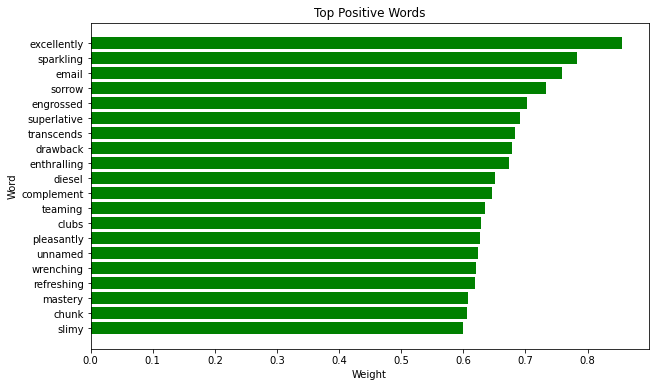

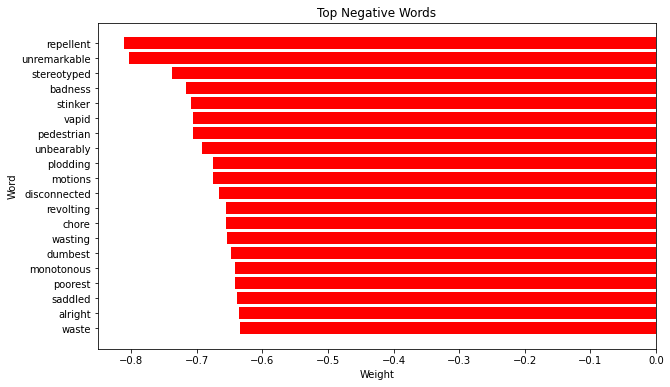

In [0]:
import matplotlib.pyplot as plt

# Bar chart for top positive words
plt.figure(figsize=(10, 6))
plt.barh(top_positive["Word"], top_positive["Weight"], color="green")
plt.title("Top Positive Words")
plt.xlabel("Weight")
plt.ylabel("Word")
plt.gca().invert_yaxis()
plt.show()

# Bar chart for top negative words
plt.figure(figsize=(10, 6))
plt.barh(top_negative["Word"], top_negative["Weight"], color="red")
plt.title("Top Negative Words")
plt.xlabel("Weight")
plt.ylabel("Word")
plt.gca().invert_yaxis()
plt.show()


Compare the performance of logistic regression (both default C and optimal C) with Naive Bayes.

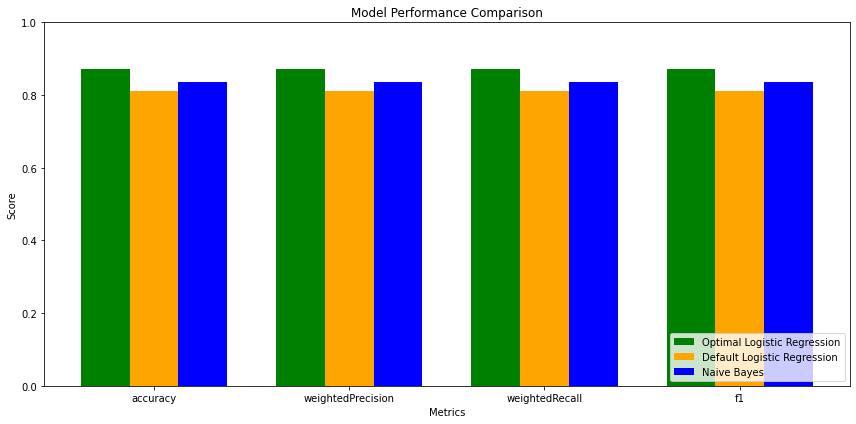

Performance Comparison (Optimal LR, Default LR, Naive Bayes):
              Metric  Optimal Logistic Regression  \
0           accuracy                     0.871291   
1  weightedPrecision                     0.872010   
2     weightedRecall                     0.871291   
3                 f1                     0.871272   

   Default Logistic Regression  Naive Bayes  
0                     0.810144     0.837076  
1                     0.810186     0.837088  
2                     0.810144     0.837076  
3                     0.810152     0.837060  


In [0]:
import numpy as np

# Step 1: Train Optimal Logistic Regression
# Assuming `optimal_C` is determined from hyperparameter tuning
optimal_C = 1  # Replace with the value you found
lr_optimal = LogisticRegression(maxIter=1000, regParam=1/optimal_C, elasticNetParam=0, labelCol="sentiment", featuresCol="features")
lr_optimal_model = lr_optimal.fit(vectorized_train)
lr_optimal_predictions = lr_optimal_model.transform(vectorized_test)

# Step 2: Train Default Logistic Regression
lr_default = LogisticRegression(labelCol="sentiment", featuresCol="features")  # Default hyperparameters
lr_default_model = lr_default.fit(vectorized_train)
lr_default_predictions = lr_default_model.transform(vectorized_test)

# Step 3: Train Naive Bayes
nb = NaiveBayes(labelCol="sentiment", featuresCol="features")  # Default hyperparameters
nb_model = nb.fit(vectorized_train)
nb_predictions = nb_model.transform(vectorized_test)

# Step 4: Initialize Evaluator and Evaluate Models
evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction")
metrics = ["accuracy", "weightedPrecision", "weightedRecall", "f1"]

results = []

for metric in metrics:
    # Evaluate each model
    optimal_lr_score = evaluator.setMetricName(metric).evaluate(lr_optimal_predictions)
    default_lr_score = evaluator.setMetricName(metric).evaluate(lr_default_predictions)
    nb_score = evaluator.setMetricName(metric).evaluate(nb_predictions)
    
    # Store results
    results.append({
        "Metric": metric,
        "Optimal Logistic Regression": optimal_lr_score,
        "Default Logistic Regression": default_lr_score,
        "Naive Bayes": nb_score
    })

# Convert results to Pandas DataFrame
results_df = pd.DataFrame(results)

# Step 5: Plot Results
# Data for plotting
metrics = results_df["Metric"]
optimal_lr_scores = results_df["Optimal Logistic Regression"]
default_lr_scores = results_df["Default Logistic Regression"]
nb_scores = results_df["Naive Bayes"]

# Set positions for the bars
x = np.arange(len(metrics))  # Metric indices
width = 0.25  # Bar width

# Plot grouped bars
plt.figure(figsize=(12, 6))
plt.bar(x - width, optimal_lr_scores, width, label="Optimal Logistic Regression", color="green")
plt.bar(x, default_lr_scores, width, label="Default Logistic Regression", color="orange")
plt.bar(x + width, nb_scores, width, label="Naive Bayes", color="blue")

# Add labels, title, and legend
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.xticks(x, metrics)  # Set x-axis labels as metrics
plt.ylim(0, 1)  # Set y-axis limit
plt.legend(loc="lower right")
plt.tight_layout()

# Display the plot
plt.show()

# Step 6: Print Results
print("Performance Comparison (Optimal LR, Default LR, Naive Bayes):")
print(results_df)
